<a href="https://colab.research.google.com/github/yubin012/OpenSource_project_Music_Instrument/blob/main/music_instrument_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q evaluate transformers==4.28.1
!pip install -U -q datasets
!pip install -q torchaudio==0.12
!add-apt-repository -y ppa:savoury1/ffmpeg4
!apt-get -qq install -y ffmpeg
!pip install -q mlflow
!pip install resampy==0.2.2
!pip install librosa numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 1.12.0 which is incompatible.
t

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fromuuu","key":"0c68e032be24cbc53779e3c385736f21"}'}

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d soumendraprasad/musical-instruments-sound-dataset

100% 5.39G/5.40G [01:03<00:00, 113MB/s]
100% 5.40G/5.40G [01:03<00:00, 91.1MB/s]


In [ ]:
!ls

kaggle.json  musical-instruments-sound-dataset.zip  sample_data


In [ ]:
! unzip musical-instruments-sound-dataset.zip

Archive:  musical-instruments-sound-dataset.zip
  inflating: Metadata_Test.csv       
  inflating: Metadata_Train.csv      
  inflating: Test_submission/Test_submission/100bpm-808-like-drum-loop-74838.wav  
  inflating: Test_submission/Test_submission/ROOM-room8-MUS-beethoven1.wav  
  inflating: Test_submission/Test_submission/ROOM-room8-MUS-beethoven2.wav  
  inflating: Test_submission/Test_submission/ROOM-room8-MUS-chords.wav  
  inflating: Test_submission/Test_submission/ROOM_room6_MUS_mozart_DEV_lg.wav  
  inflating: Test_submission/Test_submission/ROOM_room6_MUS_mozart_DEV_redmi.wav  
  inflating: Test_submission/Test_submission/ROOM_room6_MUS_mozart_DEV_stereomic.wav  
  inflating: Test_submission/Test_submission/ROOM_room6_MUS_pachelbel_DEV_amazon.wav  
  inflating: Test_submission/Test_submission/ROOM_room6_MUS_pachelbel_DEV_iphone.wav  
  inflating: Test_submission/Test_submission/ROOM_room6_MUS_pachelbel_DEV_lg.wav  
  inflating: Test_submission/Test_submission/ROOM_room7_MUS

In [ ]:
#imports
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
import librosa
import librosa.display
import resampy

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
tqdm.pandas()
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import torch
import datasets
import transformers
print(transformers.__version__)

4.28.1


#1. 데이터 전처리

In [ ]:
# before start
# 메타데이터 데이터 시각화

In [ ]:
df=pd.read_csv("Metadata_Train.csv")
df2=pd.read_csv("Metadata_Test.csv")
df

,FileName,Class
0,1-E1-Major 00.wav,Sound_Guitar
1,1-E1-Major 01.wav,Sound_Guitar
2,1-E1-Major 02.wav,Sound_Guitar
3,1-E1-Major 03.wav,Sound_Guitar
4,1-E1-Major 04.wav,Sound_Guitar
...,...,...
2624,strange-piano-73881.wav,Sound_Piano
2625,the-last-piano-112677.wav,Sound_Piano
2626,this-is-war-version-e-95411.wav,Sound_Piano
2627,tired-ghosts-piano-65013.wav,Sound_Piano


In [ ]:
df['Class'].value_counts()

Sound_Guitar    700
Sound_Drum      700
Sound_Violin    700
Sound_Piano     529
Name: Class, dtype: int64

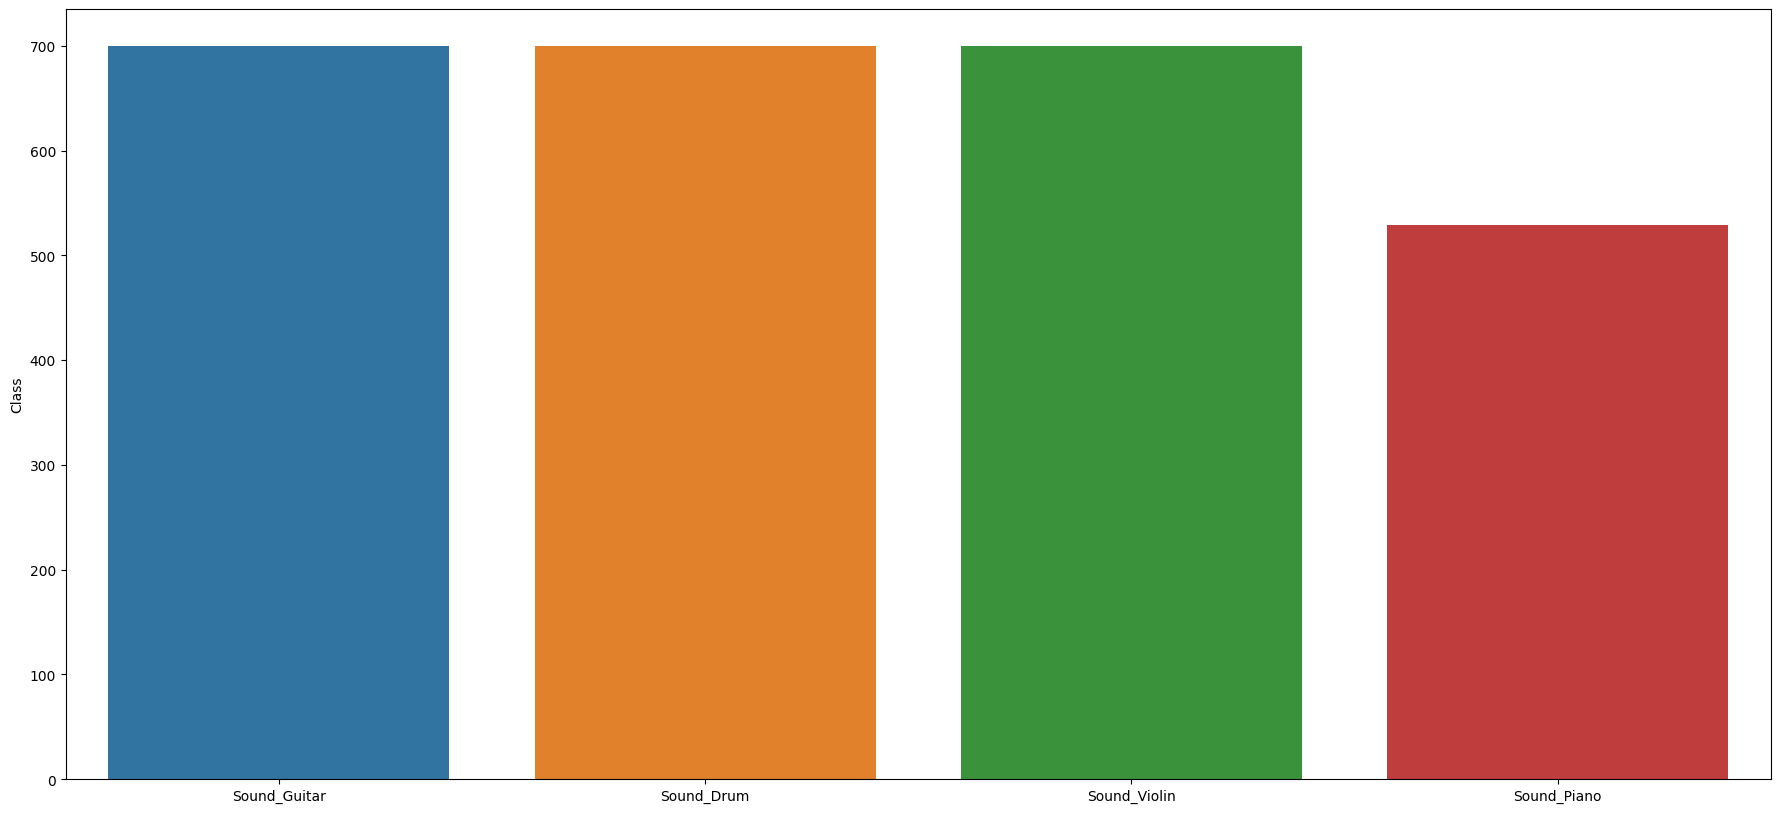

In [ ]:
plt.figure(figsize=(22, 10))
sns.barplot(x=df['Class'].value_counts().index, y=df['Class'].value_counts())
plt.xticks(rotation=0)
plt.show()

In [ ]:
RATE_HZ = 16000  # 리샘플링된 주파수(Hz)
MAX_LENGTH = 240000  # 고려할 최대 오디오 구간 길이(= RATE_HZ * SECONDS)
labels = ['Sound_Guitar', 'Sound_Drum', 'Sound_Piano','Sound_Violin']  # 음악 악기 레이블 목록

# 레이블과 해당 ID 간의 매핑을 위한 딕셔너리 생성
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

# 결과 출력
print(id2label, '\n\n', label2id)

{0: 'Sound_Guitar', 1: 'Sound_Drum', 2: 'Sound_Piano', 3: 'Sound_Violin'} 

 {'Sound_Guitar': 0, 'Sound_Drum': 1, 'Sound_Piano': 2, 'Sound_Violin': 3}


In [ ]:
# 'Class' 열의 각 값에 대한 label 값을 찾아서 'label' 열에 추가
df['label'] = df['Class'].map(label2id)

# 결과 출력
df

,FileName,Class,label
0,1-E1-Major 00.wav,Sound_Guitar,0
1,1-E1-Major 01.wav,Sound_Guitar,0
2,1-E1-Major 02.wav,Sound_Guitar,0
3,1-E1-Major 03.wav,Sound_Guitar,0
4,1-E1-Major 04.wav,Sound_Guitar,0
...,...,...,...
2624,strange-piano-73881.wav,Sound_Piano,2
2625,the-last-piano-112677.wav,Sound_Piano,2
2626,this-is-war-version-e-95411.wav,Sound_Piano,2
2627,tired-ghosts-piano-65013.wav,Sound_Piano,2


# 데이터 로드

In [ ]:
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio

## Hamoronic 시각화

In [ ]:
def visualise_audio(wav: torch.Tensor, sr:int):
    if wav.dim() == 2:
        wav = wav.mean(dim = 0)
    plt.figure(figsize= (20,5))
    plt.plot(wav, alpha =.7, c='blue')
    plt.grid()
    plt.xlabel('Time', size = 20)
    plt.ylabel('Amplitude', size = 20)
    plt.show()

In [ ]:
class MusicDataset(Dataset):
    SR = 44100

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        directory = 'Train_submission/Train_submission'
        filename = directory + '/' + self.df.iloc[idx]['FileName']
        instrument = self.df.iloc[idx]['Class']

        audio_data, sr = torchaudio.load(filename)
        if audio_data.shape[0] > 1:
            audio_data = audio_data.mean(dim=0, keepdim=True)

        instrument_label = instrument
        SR = sr
        return audio_data, instrument_label

In [ ]:
dataset = MusicDataset(df)

In [ ]:
waw, label = dataset[2627]
label

'Sound_Piano'

In [ ]:
waw.shape

torch.Size([1, 1117440])

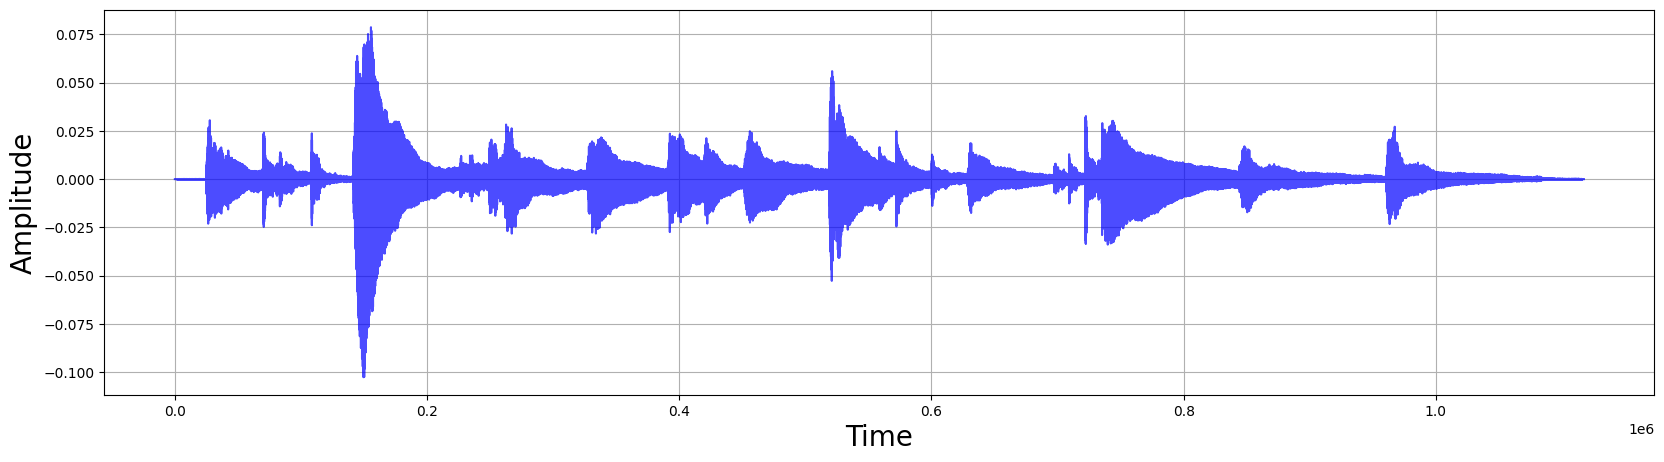

In [ ]:
visualise_audio(waw, sr = dataset.SR)

### Mel 값으로 변환하기

In [ ]:
from pathlib import Path
import torchaudio

def load_data():
    file_list = []
    sample_list = []
    for file in Path('').glob('*_submission/*_submission/*.wav'):
        sample_name = file.stem + '.wav' #re.match(r"(\d+)", file.stem).group(0)
        file_list.append(file)
        sample_list.append(str(sample_name))
    dd = pd.DataFrame()
    dd['file'] = file_list
    dd['FileName'] = sample_list
    return dd

In [ ]:
dd = load_data()
dd = dd.set_index('FileName').join(df.set_index('FileName'), how='inner')
dd = dd[dd['Class'].isin(labels)]
dd['label'] = dd['Class'].apply(lambda x: label2id[x])
selected_cols = ['file', 'label', 'Class']
dd = dd[selected_cols]
dd.sample(5).T

FileName,ROOM_room5_MUS_bartok_DEV_iphone.wav,ROOM_room3_MUS_chords_DEV_ipad.wav,G53-68604-1111-226.wav,G53-61406-1111-00124.wav,AR_Lick7_KN_Lage.wav
file,Train_submission/Train_submission/ROOM_room5_M...,Train_submission/Train_submission/ROOM_room3_M...,Train_submission/Train_submission/G53-68604-11...,Train_submission/Train_submission/G53-61406-11...,Train_submission/Train_submission/AR_Lick7_KN_...
label,2,2,0,0,0
Class,Sound_Piano,Sound_Piano,Sound_Guitar,Sound_Guitar,Sound_Guitar


In [ ]:
dd = dd.reset_index(drop=True)
dd.head()

,file,label,Class
0,Train_submission/Train_submission/029500_morni...,2,Sound_Piano
1,Train_submission/Train_submission/035568_uprig...,2,Sound_Piano
2,Train_submission/Train_submission/04-47367.wav,1,Sound_Drum
3,Train_submission/Train_submission/04-47367.wav,3,Sound_Violin
4,Train_submission/Train_submission/046578_triba...,1,Sound_Drum


In [ ]:
def Feature_extractor(file_path):
    # 음악 파일 로드, 해당 파일의 오디오 데이터와 샘플링 속도 반환
    audio, sample_rate = librosa.load(str(file_path), res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    # 정규화된 MFCC 특징 반환
    return mfccs_scaled_features,sample_rate

In [ ]:
extracted_features=[]
extracted_rate = []
for index,row in tqdm(dd.iterrows()):
    file_path = row['file']
    final_class_label = row['Class']  # Assuming 'Class' is the column containing class labels
    data, sr=Feature_extractor(file_path)
    extracted_features.append([data])
    extracted_rate.append(sr)

2629it [13:02,  3.36it/s]


In [ ]:
dd['feature']=extracted_features

In [ ]:
dd

,file,label,Class,feature
0,Train_submission/Train_submission/029500_morni...,2,Sound_Piano,"[[-391.31836, 167.01129, 11.016864, 2.181573, ..."
1,Train_submission/Train_submission/035568_uprig...,2,Sound_Piano,"[[-649.3114, 102.29075, 52.36694, 19.935278, 8..."
2,Train_submission/Train_submission/04-47367.wav,1,Sound_Drum,"[[-122.803505, 66.70081, -15.50937, 25.863022,..."
3,Train_submission/Train_submission/04-47367.wav,3,Sound_Violin,"[[-122.803505, 66.70081, -15.50937, 25.863022,..."
4,Train_submission/Train_submission/046578_triba...,1,Sound_Drum,"[[-124.61078, 46.562347, 53.75595, 67.478966, ..."
...,...,...,...,...
2624,Train_submission/Train_submission/strange-pian...,2,Sound_Piano,"[[-340.2557, 139.22214, -60.47418, 31.721258, ..."
2625,Train_submission/Train_submission/the-last-pia...,2,Sound_Piano,"[[-369.50864, 226.44633, -21.799685, -10.73569..."
2626,Train_submission/Train_submission/this-is-war-...,2,Sound_Piano,"[[-355.62, 168.70683, 15.937247, 8.451197, 13...."
2627,Train_submission/Train_submission/tired-ghosts...,2,Sound_Piano,"[[-624.9958, 124.9852, 62.212925, 22.685425, 1..."


In [ ]:
# from sklearn.preprocessing import LabelEncoder
X=np.array(dd['feature'].tolist())
y=np.array(dd["label"].tolist())

In [ ]:
X.shape

(2629, 1, 40)

In [ ]:
y

array([2, 2, 1, ..., 2, 2, 2])

In [ ]:
print(dd['feature'][0])

[array([-3.91318359e+02,  1.67011292e+02,  1.10168638e+01,  2.18157291e+00,
        9.18151760e+00, -2.75399280e+00,  5.12870312e-01,  1.06217706e+00,
       -4.89515162e+00, -7.69560194e+00, -1.03921299e+01, -7.56495667e+00,
        1.54135942e+00,  6.21416521e+00,  2.47368956e+00, -1.23543131e+00,
        1.15466738e+00, -4.85515177e-01,  5.45977533e-01,  8.08689880e+00,
        5.67252970e+00, -2.92514157e+00, -2.26791358e+00,  1.70364845e+00,
        1.18935561e+00, -1.01181686e+00, -2.95740604e+00,  4.92143965e+00,
        6.76138973e+00, -9.50563049e+00, -1.36096325e+01, -1.33412504e+00,
        2.62620258e+00, -2.04868960e+00,  3.42931449e-01,  3.60147166e+00,
        1.80371070e+00,  3.33607078e+00,  4.95880365e+00,  3.55356455e+00],
      dtype=float32)]


In [ ]:
dd['file'][0]

PosixPath('Train_submission/Train_submission/029500_morning-rain-piano-65875.wav')

In [ ]:
#sound_piano
#y, sr = librosa.load('Train_submission/Train_submission/029500_morning-rain-piano-65875.wav')
#S = librosa.feature.melspectrogram(y=y, sr=sr)
#S_DB = librosa.amplitude_to_db(S, ref=np.max)

#plt.figure(figsize=(16,6))
#librosa.display.specshow(S_DB, sr=sr,hop_length=512, x_axis='time',y_axis='log')
#plt.colorbar()
#plt.show()

#### Mel Frequency 시각화

<Figure size 1400x400 with 0 Axes>

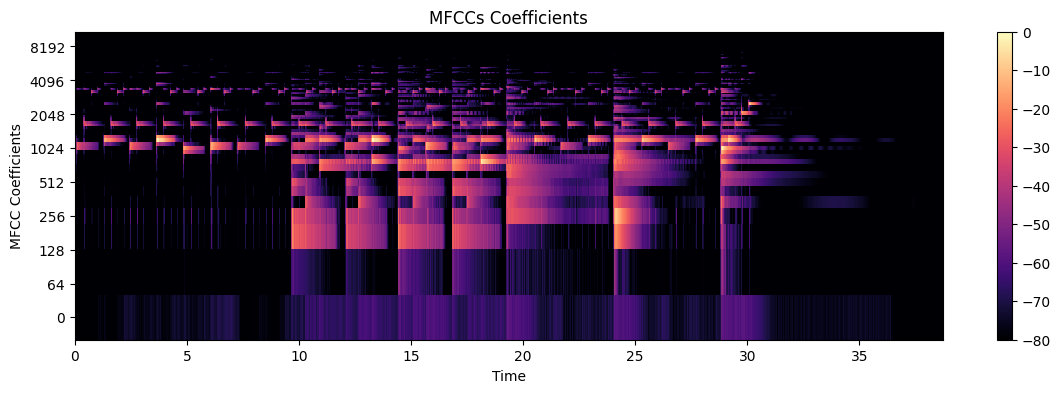

In [ ]:
#sound_piano
plt.figure(figsize=(14, 4))

mfcc, sr = librosa.load(str(dd['file'][0]))
mfccs_data =  librosa.feature.melspectrogram(y=mfcc, sr=sr)
S_DB = librosa.amplitude_to_db(mfccs_data, ref=np.max)

#Display the MFCCs
plt.figure(figsize=(14, 4))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time',y_axis='log')
plt.colorbar()
plt.title('MFCCs Coefficients')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

In [ ]:
def plot_logfbank_spectrograms(signals, signal_names, sr, hop_length, nfilt, nfft):
    fig, axes = plt.subplots(nrows=len(signals), figsize=(16, 5 * len(signals)))

    for i, (signal, name) in enumerate(zip(signals, signal_names)):
        # Extract log mel filterbank features
        logfbank_data = librosa.feature.melspectrogram(y=signal, sr=sr, hop_length=hop_length, n_fft=nfft, n_mels=nfilt)
        logfbank_data = librosa.power_to_db(logfbank_data, ref=np.max)

        # Display the log mel filterbank features
        ax = axes[i] if len(signals) > 1 else axes
        im = librosa.display.specshow(logfbank_data, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis', ax=ax)
        fig.colorbar(im, ax=ax, format="%+2.0f dB")

        ax.set(title=f'Log Mel Filterbank Spectrogram - {name}', xlabel='Time', ylabel='Mel frequency')

    plt.tight_layout()
    plt.show()

#데이터셋 분할

In [ ]:
from tensorflow.keras.utils import to_categorical #one-hot-coding
from sklearn.preprocessing import LabelEncoder

LE=LabelEncoder()
y=to_categorical(LE.fit_transform(y)) #원핫코딩 변환 (다중클래스 분류)

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)


In [ ]:
print("Shape Of X_train:",X_train.shape)
print("Shape Of X_test:",X_test.shape)
print("Shape Of y_train:",y_train.shape)
print("Shape Of y_test:",y_test.shape)

Shape Of X_train: (2103, 1, 40)
Shape Of X_test: (526, 1, 40)
Shape Of y_train: (2103, 4)
Shape Of y_test: (526, 4)


In [ ]:
# X_train의 두 번째 차원 제거 (각 샘플의 프레임들을 평탄화)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

In [ ]:
num_labels = y.shape[1]

In [ ]:
num_labels

4

In [ ]:
y

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

#모델 정의

In [ ]:
# 모델 정의
model = Sequential()
model.add(Dense(100, input_shape=(40,), activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(200, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(200, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))

# 다중 라벨 분류를 위해 softmax 대신 sigmoid 활성화 함수 사용
model.add(Dense(num_labels, activation='sigmoid'))

model.summary()

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 100)               4100      
                                                                 
 dropout_16 (Dropout)        (None, 100)               0         
                                                                 
 dense_23 (Dense)            (None, 200)               20200     
                                                                 
 dropout_17 (Dropout)        (None, 200)               0         
                                                                 
 dense_24 (Dense)            (None, 200)               40200     
                                                                 
 dropout_18 (Dropout)        (None, 200)               0         
                                                                 
 dense_25 (Dense)            (None, 100)              

#훈련시키기

Epoch 1/100
65/66 [============================>.] - ETA: 0s - loss: 0.2181 - accuracy: 0.7048
Epoch 1: val_loss did not improve from 0.22351
66/66 [==============================] - 0s 6ms/step - loss: 0.2189 - accuracy: 0.7042 - val_loss: 0.2365 - val_accuracy: 0.7072
Epoch 2/100
65/66 [============================>.] - ETA: 0s - loss: 0.2218 - accuracy: 0.7072
Epoch 2: val_loss did not improve from 0.22351
66/66 [==============================] - 0s 4ms/step - loss: 0.2227 - accuracy: 0.7071 - val_loss: 0.2338 - val_accuracy: 0.7129
Epoch 3/100
50/66 [=====================>........] - ETA: 0s - loss: 0.2221 - accuracy: 0.7094
Epoch 3: val_loss did not improve from 0.22351
66/66 [==============================] - 0s 4ms/step - loss: 0.2234 - accuracy: 0.7052 - val_loss: 0.2376 - val_accuracy: 0.7110
Epoch 4/100
60/66 [==========================>...] - ETA: 0s - loss: 0.2254 - accuracy: 0.7026
Epoch 4: val_loss did not improve from 0.22351
66/66 [==============================] - 0s 4

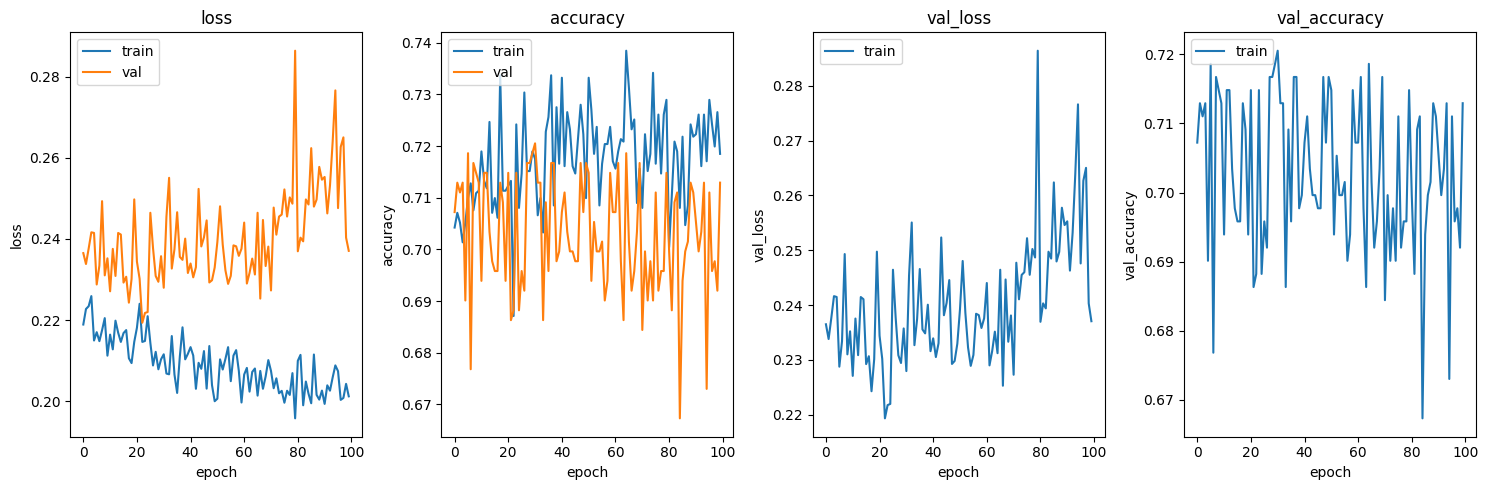

Test Accuracy: 0.7129277586936951


In [ ]:
from sklearn.metrics import confusion_matrix
# 훈련
history = model.fit(X_train_reshaped, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test_reshaped, y_test), callbacks=[checkpointer])

# 훈련 결과 시각화
plot_history(history)

# 모델 평가
test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy[1]}")


In [ ]:

# 모델 저장
model.save('multilabel_instrument_classification.h5')

In [ ]:
model.load_weights('multilabel_instrument_classification.h5')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델 예측 수행
y_preds = model.predict(X_test_reshaped)

# 예측 결과 해석
def interpret_multi_label_prediction(prediction, label2id):
    predicted_labels = [label2id[i] for i in range(len(prediction)) if prediction[i] > 0.5]
    return predicted_labels

# 예측 결과를 해석하여 각 샘플에 대한 예측 악기 목록을 얻습니다.
predicted_labels_list = [interpret_multi_label_prediction(prediction, id2label) for prediction in y_preds]

# 정답 악기 목록을 얻습니다.
true_labels_list = [[id2label[i] for i in range(len(y_test[j])) if y_test[j][i] == 1] for j in range(len(y_test))]

# 예측 악기 목록 및 정답 악기 목록 출력
for i in range(5):
    print(f"Sample {i + 1}")
    print(f"Predicted: {predicted_labels_list[i]}")
    print(f"True Labels: {true_labels_list[i]}\n")





17/17 [==============================] - 0s 2ms/step
Sample 1
Predicted: ['Sound_Violin']
True Labels: ['Sound_Drum']

Sample 2
Predicted: ['Sound_Guitar']
True Labels: ['Sound_Guitar']

Sample 3
Predicted: ['Sound_Piano']
True Labels: ['Sound_Piano']

Sample 4
Predicted: ['Sound_Piano']
True Labels: ['Sound_Piano']

Sample 5
Predicted: ['Sound_Violin']
True Labels: ['Sound_Drum']



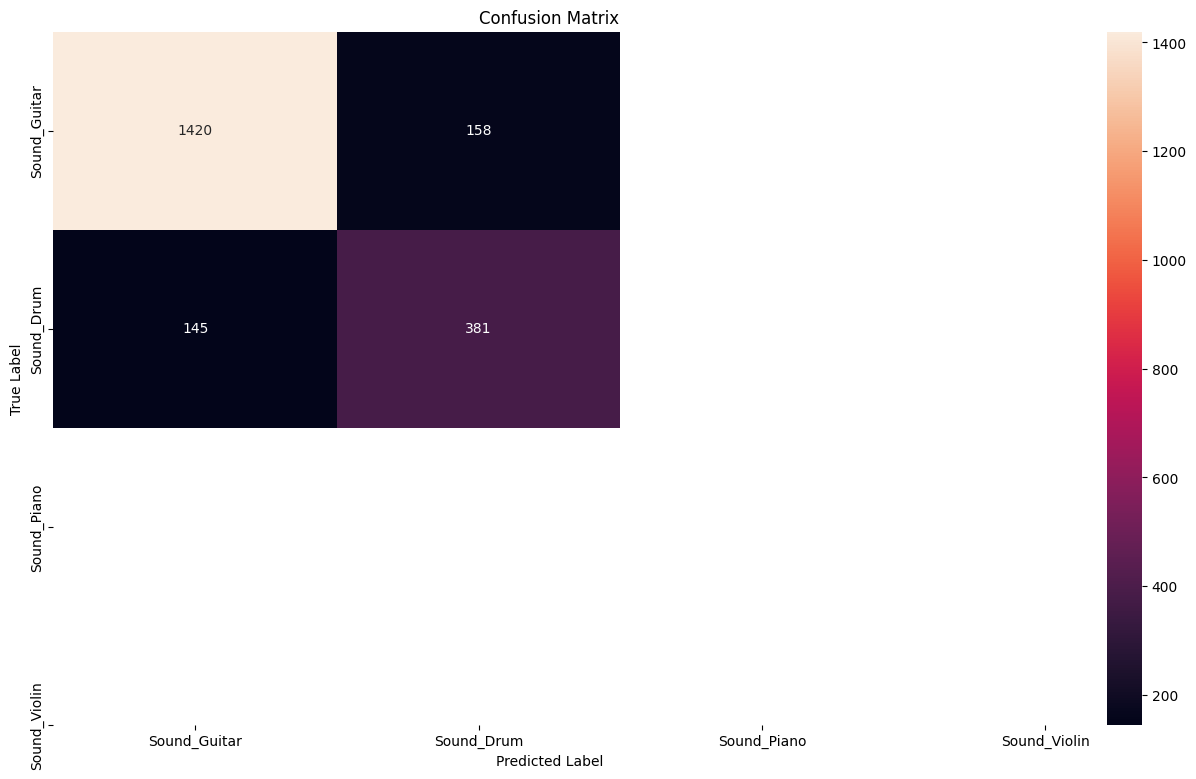

In [ ]:
# 혼동 행렬 계산
conf_matrix = confusion_matrix(np.concatenate(y_test, axis=0), np.concatenate(y_preds, axis=0) > 0.5)

# 혼동 행렬 시각화
plt.figure(figsize=(16, 9))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    xticklabels=["Sound_Guitar", "Sound_Drum", "Sound_Piano", "Sound_Violin"],
    yticklabels=["Sound_Guitar", "Sound_Drum", "Sound_Piano", "Sound_Violin"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
#Youtube APUI 를 이용해서 음성 파일 추출
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.6 MB/s eta 0:00:00


In [ ]:
from pytube import YouTube

def download_youtube_audio(youtube_url, start_time, end_time, output_path):
    yt = YouTube(youtube_url)
    video = yt.streams.filter(only_audio=True).first()

    # Download audio with a specific start and end time
    video.download(output_path, filename=f'{start_time}_{end_time}.mp3')

# Example usage
youtube_url = 'https://www.youtube.com/watch?v=1JMOZfhuHb8'
start_time = 10  # Example start time in seconds
end_time = 60    # Example end time in seconds
output_path = 'path/to/save/audio'
download_youtube_audio(youtube_url, start_time, end_time, output_path)

In [ ]:
# 오디오 파일을 모델 입력 형식으로 가공
def preprocess_audio(audio_path):
    # Load the audio file
    audio, sr = librosa.load(audio_path, res_type='kaiser_fast')

    # Extract MFCC features
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    # Reshape for model input
    model_input = mfccs_scaled_features.reshape(1, -1)

    return model_input


# 예측 결과 해석
def interpret_prediction(prediction, label2id):
    predicted_label_id = np.argmax(prediction)
    predicted_label = label2id[predicted_label_id]
    return predicted_label


In [ ]:
# 다운로드한 오디오 파일 전처리 및 모델 예측
downloaded_audio_path = f'{output_path}/{start_time}_{end_time}.mp3'
model_input = preprocess_audio(downloaded_audio_path)
prediction = model.predict(model_input)
predicted_label = interpret_prediction(prediction, id2label)

print(f"Predicted Instrument: {predicted_label}")

1/1 [==============================] - 0s 109ms/step
Predicted Instrument: Sound_Violin


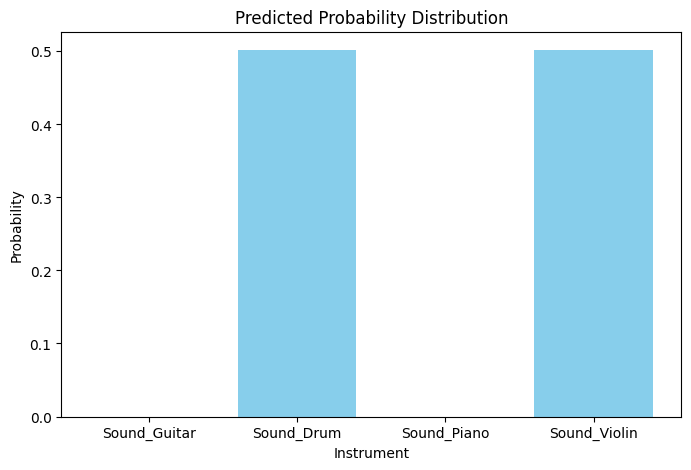

In [ ]:
# 예측 결과를 시각화
plt.figure(figsize=(8, 5))
plt.bar(id2label.values(), prediction.flatten(), color='skyblue')
plt.title("Predicted Probability Distribution")
plt.xlabel("Instrument")
plt.ylabel("Probability")
plt.show()